In [215]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [216]:
orig_img = cv2.imread("assets/images/photo_2025-05-27_17-01-25.jpg")
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
seg_mask = cv2.imread("assets/results/resnet34/photo_2025-05-27_17-01-25.png")
seg_mask = cv2.cvtColor(seg_mask, cv2.COLOR_BGR2GRAY)

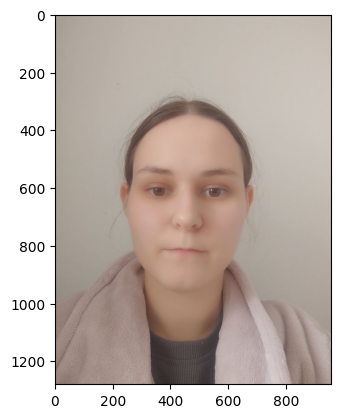

In [217]:
plt.imshow(orig_img)

In [218]:
np.unique(seg_mask)

array([ 0,  1,  2,  4,  7, 10, 12, 13, 14, 16, 17], dtype=uint8)

In [219]:
seg_mask_face_binary = np.zeros_like(seg_mask, dtype=np.uint8)
seg_mask_face_binary[seg_mask != 0] = 255 

seg_mask_eyes_binary = np.zeros_like(seg_mask, dtype=np.uint8)
seg_mask_eyes_binary[(seg_mask == 4) | (seg_mask == 5)] = 255 

seg_mask_mouth_binary = np.zeros_like(seg_mask, dtype=np.uint8)
seg_mask_mouth_binary[(seg_mask == 11) | (seg_mask == 12) | (seg_mask == 13)] = 255 

print("Binary masks created for face, eyes, and mouth.")

Binary masks created for face, eyes, and mouth.


In [220]:
seg_mask_mouth = seg_mask.copy()
seg_mask_face = seg_mask.copy()
seg_mask_eyes = seg_mask.copy()

seg_mask_eyes[(seg_mask_eyes!=4) & (seg_mask_eyes!=5)] = 0

seg_mask_mouth[(seg_mask_mouth!=11) & (seg_mask_mouth!=12) & (seg_mask_mouth!=13)] = 0

seg_mask_face[seg_mask_face!=1] = 0

In [221]:
def find_part_rect(part_seg_mask):
    cnt, _ = cv2.findContours(part_seg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(cnt) < 1:
        return np.asarray([0,0,0,0])
    print(cnt[0].min(axis=0), cnt[0].max(axis=0))
    return np.asarray(cv2.boundingRect(cnt[0][:,0,:]))

def left_right_eye(seg_mask_eyes):
    cnt, _ = cv2.findContours(seg_mask_eyes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(cnt) == 2:
        eyes_rects = [np.asarray(cv2.boundingRect(cnt[i][:,0,:])) for i in range(2)]
        eyes_rects = np.sort(eyes_rects, axis=0)
        print(eyes_rects)
        return eyes_rects
    
    elif len(cnt) == 1:
        eye_rect = np.asarray(cv2.boundingRect(cnt[0][:, 0, :]))
        print("Found 1 eye:", eye_rect)
        return eye_rect, None

    else:
        print(f"Found {len(cnt)} eyes — unsupported number.")
        return None, None

In [ ]:
def rect_to_rotated_box_points(rect_xywh):
    x, y, w, h = float(rect_xywh[0]), float(rect_xywh[1]), float(rect_xywh[2]), float(rect_xywh[3])
    
    center = (x + w / 2, y + h / 2)
    size = (w, h)
    angle = 0.0

    rotated_rect_info = (center, size, angle) 
    
    return cv2.boxPoints(rotated_rect_info).astype(np.int32)

def get_moment_and_rotated_rect(binary_part_mask):
    """
    Обчислює моменти, центроїд та орієнтований мінімальний прямокутник для бінарної маски.
    Повертає кортеж: (moments, centroid_xy, rotated_rect_info, box_points)
    """
    contours, _ = cv2.findContours(binary_part_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None
    
    largest_contour = max(contours, key=cv2.contourArea)

    temp_mask_for_moments = np.zeros_like(binary_part_mask)
    cv2.drawContours(temp_mask_for_moments, [largest_contour], -1, 255, thickness=cv2.FILLED)
    
    M = cv2.moments(temp_mask_for_moments)

    if M["m00"] == 0:  
        return None

    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])

    rotated_rect = cv2.minAreaRect(largest_contour)
    
    box = cv2.boxPoints(rotated_rect).astype(np.int32)

    return M, (cX, cY), rotated_rect, box 

def get_fallback_eye_rects(face_rect, left_eye_raw_rect_xywh, right_eye_raw_rect_xywh, img_shape):
    """
    Обчислює або уточнює вісь-вирівняні прямокутники очей, використовуючи face_rect як базову лінію.
    Ця функція призначена для сценаріїв, коли детектор не знайшов одного або обох очей.
    """
    fx, fy, fw, fh = int(face_rect[0]), int(face_rect[1]), int(face_rect[2]), int(face_rect[3])
    img_h, img_w = img_shape[:2]

    target_eye_width = int(fw / 5.0)
    target_eye_height = int(target_eye_width * 0.6)

    center_face_x = fx + fw // 2
    center_face_y = fy + fh // 2

    def create_rect_from_center_and_size(cx, cy, w, h):
        x = max(0, cx - w // 2)
        y = max(0, cy - h // 2)
        w_final = min(w, img_w - x)
        h_final = min(h, img_h - y)
        return [int(x), int(y), int(w_final), int(h_final)]

    adjusted_left_eye_xywh = left_eye_raw_rect_xywh
    adjusted_right_eye_xywh = right_eye_raw_rect_xywh

    if adjusted_left_eye_xywh is not None and adjusted_right_eye_xywh is None:
        lx, ly, lw, lh = int(adjusted_left_eye_xywh[0]), int(adjusted_left_eye_xywh[1]), \
                         int(adjusted_left_eye_xywh[2]), int(adjusted_left_eye_xywh[3])
        center_lx = lx + lw // 2
        center_ly = ly + lh // 2
        dist_x = center_face_x - center_lx 
        mirror_cx = center_face_x + dist_x
        adjusted_right_eye_xywh = create_rect_from_center_and_size(mirror_cx, center_ly, target_eye_width, target_eye_height)

    elif adjusted_right_eye_xywh is not None and adjusted_left_eye_xywh is None:
        rx, ry, rw, rh = int(adjusted_right_eye_xywh[0]), int(adjusted_right_eye_xywh[1]), \
                         int(adjusted_right_eye_xywh[2]), int(adjusted_right_eye_xywh[3])
        center_rx = rx + rw // 2
        center_ry = ry + rh // 2
        dist_x = center_rx - center_face_x
        mirror_cx = center_face_x - dist_x
        adjusted_left_eye_xywh = create_rect_from_center_and_size(mirror_cx, center_ry, target_eye_width, target_eye_height)

    if adjusted_left_eye_xywh is None and adjusted_right_eye_xywh is None:
        eye_y_center = fy + int(fh * 0.3) 
        left_eye_x_center = fx + int(fw * 0.25) 
        right_eye_x_center = fx + int(fw * 0.75) 

        adjusted_left_eye_xywh = create_rect_from_center_and_size(left_eye_x_center, eye_y_center, target_eye_width, target_eye_height)
        adjusted_right_eye_xywh = create_rect_from_center_and_size(right_eye_x_center, eye_y_center, target_eye_width, target_eye_height)
        
    return adjusted_left_eye_xywh, adjusted_right_eye_xywh

def get_fallback_mouth_rect(face_rect, img_shape):
    
    fx, fy, fw, fh = int(face_rect[0]), int(face_rect[1]), int(face_rect[2]), int(face_rect[3])
    img_h, img_w = img_shape[:2]

    mouth_w_ratio = 0.4
    mouth_h_ratio = 0.15
    
    mouth_x_center = fx + fw // 2
    mouth_y_center = fy + int(fh * 0.75) 
    
    mouth_w = int(fw * mouth_w_ratio)
    mouth_h = int(fh * mouth_h_ratio)

    mouth_x = max(0, mouth_x_center - mouth_w // 2)
    mouth_y = max(0, mouth_y_center - mouth_h // 2)
    mouth_w_final = min(mouth_w, img_w - mouth_x)
    mouth_h_final = min(mouth_h, img_h - mouth_y)

    return [int(mouth_x), int(mouth_y), int(mouth_w_final), int(mouth_h_final)]

In [223]:
left_eye_rect, right_eye_rect = left_right_eye(seg_mask_eyes)
mouth_rect = find_part_rect(seg_mask_mouth)
face_rect = find_part_rect(seg_mask_face)

[[326 597  63  25]
 [518 600  70  35]]
[[402 808]] [[499 822]]
[[253 347]] [[658 954]]


In [224]:
# cnt, _ = cv2.findContours(seg_mask_eyes, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# tmp_mask = np.zeros(shape=seg_mask_eyes.shape, dtype=seg_mask_eyes.dtype)
# tmp_mask = cv2.drawContours(tmp_mask, cnt, 1, color=255, thickness=cv2.FILLED)

In [225]:
face_contours, _ = cv2.findContours(seg_mask_face_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
face_rect_xywh = None
if face_contours:
    largest_face_contour = max(face_contours, key=cv2.contourArea)
    face_rect_xywh = cv2.boundingRect(largest_face_contour)
else:
    print("Warning: No face detected. Fallback for eyes/mouth might not be accurate.")

left_eye_final_data = None
right_eye_final_data = None
mouth_final_data = None
face_final_data = None

if face_rect_xywh is not None:
    fx, fy, fw, fh = face_rect_xywh
    face_centroid = (fx + fw // 2, fy + fh // 2)
    face_box_points = rect_to_rotated_box_points(face_rect_xywh)
    face_rotated_rect_info = (None, (fw, fh), 0.0) 
    face_final_data = (face_box_points, face_centroid, face_rotated_rect_info)
    print(f"Face bounding box obtained: {face_rect_xywh}")

eye_contours, _ = cv2.findContours(seg_mask_eyes_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
detected_eyes_full_info = [] 

for contour in eye_contours:
    temp_eye_mask = np.zeros_like(seg_mask_eyes_binary)
    cv2.drawContours(temp_eye_mask, [contour], -1, 255, thickness=cv2.FILLED)
    
    part_info = get_moment_and_rotated_rect(temp_eye_mask)
    if part_info:
        detected_eyes_full_info.append(part_info)

if len(detected_eyes_full_info) == 2:
    detected_eyes_full_info.sort(key=lambda x: x[1][0]) 
    
    left_eye_final_data = (detected_eyes_full_info[0][3], detected_eyes_full_info[0][1], detected_eyes_full_info[0][2])
    right_eye_final_data = (detected_eyes_full_info[1][3], detected_eyes_full_info[1][1], detected_eyes_full_info[1][2])
    print(f"Detected both eyes using moments and rotated bounding boxes.")

elif len(detected_eyes_full_info) == 1 and face_rect_xywh is not None:
    detected_eye_full_info = detected_eyes_full_info[0]
    
    detected_eye_xywh = cv2.boundingRect(detected_eye_full_info[3])
    
    if detected_eye_xywh[0] < face_rect_xywh[0] + face_rect_xywh[2] / 2: 
        left_eye_detected_for_fallback_xywh = detected_eye_xywh
        right_eye_detected_for_fallback_xywh = None
        left_eye_final_data = (detected_eye_full_info[3], detected_eye_full_info[1], detected_eye_full_info[2]) 
    else: 
        left_eye_detected_for_fallback_xywh = None
        right_eye_detected_for_fallback_xywh = detected_eye_xywh
        right_eye_final_data = (detected_eye_full_info[3], detected_eye_full_info[1], detected_eye_full_info[2]) 

    inferred_left_eye_xywh, inferred_right_eye_xywh = get_fallback_eye_rects(
        face_rect_xywh, 
        left_eye_detected_for_fallback_xywh, 
        right_eye_detected_for_fallback_xywh, 
        orig_img.shape
    )
    
    if left_eye_final_data is None and inferred_left_eye_xywh is not None:
        centroid_l = (inferred_left_eye_xywh[0] + inferred_left_eye_xywh[2]//2, inferred_left_eye_xywh[1] + inferred_left_eye_xywh[3]//2)
        size_l = (inferred_left_eye_xywh[2], inferred_left_eye_xywh[3])
        left_eye_final_data = (rect_to_rotated_box_points(inferred_left_eye_xywh), centroid_l, (None, size_l, 0))
        print(f"Detected one eye using moments and inferred the other (left). Fallback rect: {inferred_left_eye_xywh}")
    
    if right_eye_final_data is None and inferred_right_eye_xywh is not None:
        centroid_r = (inferred_right_eye_xywh[0] + inferred_right_eye_xywh[2]//2, inferred_right_eye_xywh[1] + inferred_right_eye_xywh[3]//2)
        size_r = (inferred_right_eye_xywh[2], inferred_right_eye_xywh[3])
        right_eye_final_data = (rect_to_rotated_box_points(inferred_right_eye_xywh), centroid_r, (None, size_r, 0))
        print(f"Detected one eye using moments and inferred the other (right). Fallback rect: {inferred_right_eye_xywh}")

elif len(detected_eyes_full_info) == 0 and face_rect_xywh is not None:
    inferred_left_eye_xywh, inferred_right_eye_xywh = get_fallback_eye_rects(face_rect_xywh, None, None, orig_img.shape)
    
    centroid_l = (inferred_left_eye_xywh[0] + inferred_left_eye_xywh[2]//2, inferred_left_eye_xywh[1] + inferred_left_eye_xywh[3]//2)
    size_l = (inferred_left_eye_xywh[2], inferred_left_eye_xywh[3])
    left_eye_final_data = (rect_to_rotated_box_points(inferred_left_eye_xywh), centroid_l, (None, size_l, 0))

    centroid_r = (inferred_right_eye_xywh[0] + inferred_right_eye_xywh[2]//2, inferred_right_eye_xywh[1] + inferred_right_eye_xywh[3]//2)
    size_r = (inferred_right_eye_xywh[2], inferred_right_eye_xywh[3])
    right_eye_final_data = (rect_to_rotated_box_points(inferred_right_eye_xywh), centroid_r, (None, size_r, 0))
    print(f"Inferred both eyes using fallback.")

else:
    print(f"Warning: Could not robustly process eyes. Detected {len(detected_eyes_full_info)} eye parts. Face rect was {face_rect_xywh}.")


mouth_detected_full_info = get_moment_and_rotated_rect(seg_mask_mouth_binary)
if mouth_detected_full_info:
    mouth_final_data = (mouth_detected_full_info[3], mouth_detected_full_info[1], mouth_detected_full_info[2])
    print("Detected mouth using moments and rotated bounding box.")
elif face_rect_xywh is not None:
    inferred_mouth_xywh = get_fallback_mouth_rect(face_rect_xywh, orig_img.shape)
    centroid_m = (inferred_mouth_xywh[0] + inferred_mouth_xywh[2]//2, inferred_mouth_xywh[1] + inferred_mouth_xywh[3]//2)
    size_m = (inferred_mouth_xywh[2], inferred_mouth_xywh[3])
    mouth_final_data = (rect_to_rotated_box_points(inferred_mouth_xywh), centroid_m, (None, size_m, 0))
    print("Inferred mouth using fallback.")
else:
    print("Warning: Could not process mouth. No face detected or no fallback available.")

print("Facial parts processing complete.")

Face bounding box obtained: (0, 277, 958, 1003)
Detected both eyes using moments and rotated bounding boxes.
Detected mouth using moments and rotated bounding box.
Facial parts processing complete.


{'m00': 436050.0,
 'm10': 240694755.0,
 'm01': 267729600.0,
 'm20': 132988371885.0,
 'm11': 147784033140.0,
 'm02': 164411137800.0,
 'm30': 73548995379045.0,
 'm21': 81653506184880.0,
 'm12': 90753432944340.0,
 'm03': 100981281324000.0,
 'mu20': 127541511.16665511,
 'mu11': 268713.333320482,
 'mu02': 28294740.350862063,
 'mu30': 88753029.30853811,
 'mu21': -95386504.37539402,
 'mu12': -18304527.63251461,
 'mu03': 20372798.615785718,
 'nu20': 0.0006707782570790591,
 'nu11': 1.4132423218907381e-06,
 'nu02': 0.00014881034765422982,
 'nu30': 7.068747329634769e-07,
 'nu21': -7.597071371420751e-07,
 'nu12': -1.4578666421937677e-07,
 'nu03': 1.62259437153283e-07}

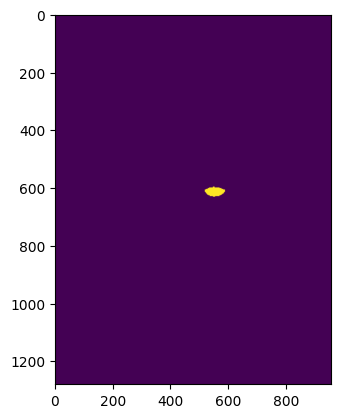

In [226]:
plt.imshow(tmp_mask)
cv2.moments(tmp_mask)

In [227]:
mouth_moments = cv2.moments(seg_mask_mouth)

mouth_x = mouth_moments["m10"] // mouth_moments["m00"]
mouth_y = mouth_moments["m01"] // mouth_moments["m00"]

In [228]:
mxy = np.asarray([mouth_x, mouth_y], dtype=np.int32)


In [229]:
img = orig_img.copy()
img = cv2.rectangle(img.copy(), left_eye_rect[0:2],  left_eye_rect[0:2]+left_eye_rect[2:4],
                    color=(255,255,0), thickness=6)

img = cv2.rectangle(img.copy(), right_eye_rect[0:2],  right_eye_rect[0:2]+right_eye_rect[2:4],
                    color=(255,255,0), thickness=6)

img = cv2.rectangle(img.copy(), mouth_rect[0:2],  mouth_rect[0:2]+mouth_rect[2:4],
                    color=(255,255,0), thickness=6)

img = cv2.drawMarker(img, mxy, color=(255, 0, 0), 
                     markerType=cv2.MARKER_CROSS, 
                     markerSize=10, thickness=10)

img = cv2.rectangle(img.copy(), face_rect[0:2],  face_rect[0:2]+face_rect[2:4],
                    color=(0,0,255), thickness=6)

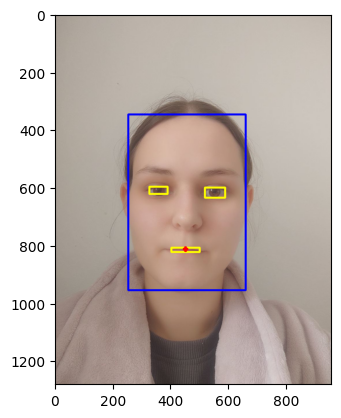

In [230]:
plt.imshow(img)

Face: Centroid=(479, 778), RotatedRect=(None, (958, 1003), 0.0), BoxPoints=[[   0 1280]
 [   0  277]
 [ 958  277]
 [ 958 1280]]
Left Eye: Centroid=(357, 611), RotatedRect=((357.0, 612.0), (24.0, 62.0), 90.0), BoxPoints=[[326 600]
 [388 600]
 [388 624]
 [326 624]]
Right Eye: Centroid=(551, 613), RotatedRect=((552.5, 614.0), (34.0, 69.0), 90.0), BoxPoints=[[518 597]
 [587 597]
 [587 631]
 [518 631]]
Mouth: Centroid=(452, 813), RotatedRect=((450.5, 815.0), (14.0, 97.0), 90.0), BoxPoints=[[402 808]
 [499 808]
 [499 822]
 [402 822]]


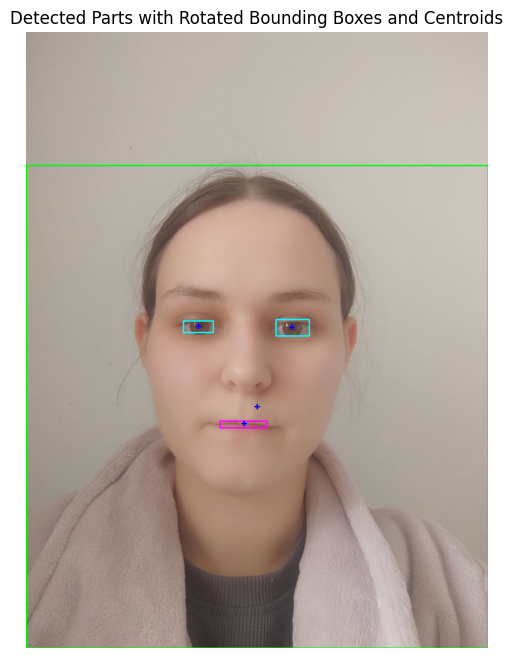

In [231]:
img_with_rects = orig_img.copy()

def draw_part_info(img, part_data, color_rect, color_centroid, label_prefix=""):
    if part_data:
        box_points = part_data[0]
        centroid = part_data[1]
        
        cv2.polylines(img, [box_points], True, color_rect, 2)
        
        cv2.drawMarker(img, centroid, color_centroid, 
                       markerType=cv2.MARKER_CROSS, 
                       markerSize=10, thickness=2)
        
        rect_info = part_data[2] 
        if rect_info and rect_info[2] is not None: 
            print(f"{label_prefix}: Centroid={centroid}, RotatedRect={rect_info}, BoxPoints={box_points}")
        else:
            x,y,w,h = cv2.boundingRect(box_points)
            print(f"{label_prefix}: Centroid={centroid}, FallbackRect=(x={x},y={y},w={w},h={h}), BoxPoints={box_points}")


draw_part_info(img_with_rects, face_final_data, (0, 255, 0), (0, 0, 255), "Face") 
draw_part_info(img_with_rects, left_eye_final_data, (0, 255, 255), (0, 0, 255), "Left Eye") 
draw_part_info(img_with_rects, right_eye_final_data, (0, 255, 255), (0, 0, 255), "Right Eye") 
draw_part_info(img_with_rects, mouth_final_data, (255, 0, 255), (0, 0, 255), "Mouth") 

plt.figure(figsize=(10, 8))
plt.imshow(img_with_rects)
plt.title("Detected Parts with Rotated Bounding Boxes and Centroids")
plt.axis('off')
plt.show()
